# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


In [4]:
random.seed(24)
data = data[data['pork_bill']==1].append(data[data['pork_bill']==0].reset_index(drop=True).loc[[random.randint(0, 2500) for i in range(2500)]]).reset_index(drop=True)

#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/ Testing Set

In [8]:
data_labels = data.pork_bill.values

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (3356, 527) 
Shape of X Test : (1654, 527) 
Shape of Y Trian: (3356,) 
Shape of Y Test : (1654,)


In [10]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 3356 
 Not Pork vs Pork: {0: 1705, 1: 1651}


In [11]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 1654 
 Not Pork vs Pork: {0: 795, 1: 859}


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [12]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size,emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,padding="valid",activation="relu")
        self.sixgram = layers.Conv1D(filters=nb_filters,kernel_size=6,padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1, x_2, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [13]:
VOCAB_SIZE = tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 250
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [14]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1] , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  484000    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  100100    
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  0 (unused)
_________________________________________________________________
global_max_pooling1d (Global multiple                  0      

#### (3) Check Point Path

In [15]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [16]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [17]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop]
        )
ckpt_manager.save()

Epoch 1/80
14/14 [==============================] - 23s 2s/step - loss: 0.6428 - accuracy: 0.6847 - val_loss: 0.5362 - val_accuracy: 0.8192
Epoch 2/80
14/14 [==============================] - 22s 2s/step - loss: 0.3871 - accuracy: 0.8793 - val_loss: 0.2734 - val_accuracy: 0.9015
Epoch 3/80
14/14 [==============================] - 22s 2s/step - loss: 0.1943 - accuracy: 0.9282 - val_loss: 0.1807 - val_accuracy: 0.9293
Epoch 4/80
14/14 [==============================] - 21s 2s/step - loss: 0.0979 - accuracy: 0.9714 - val_loss: 0.1430 - val_accuracy: 0.9492
Epoch 5/80
14/14 [==============================] - 22s 2s/step - loss: 0.0564 - accuracy: 0.9851 - val_loss: 0.1342 - val_accuracy: 0.9522
Epoch 6/80
14/14 [==============================] - 28s 2s/step - loss: 0.0375 - accuracy: 0.9875 - val_loss: 0.1410 - val_accuracy: 0.9510
Epoch 7/80
14/14 [==============================] - 27s 2s/step - loss: 0.0325 - accuracy: 0.9887 - val_loss: 0.1480 - val_accuracy: 0.9510
Epoch 8/80
14/14 [==

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [18]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.642769,0.684744,0.536221,0.819226
1,0.387111,0.879321,0.273432,0.901451
2,0.194271,0.928188,0.180747,0.929262
3,0.097936,0.971395,0.143038,0.949214
4,0.056357,0.985101,0.134210,0.952237
5,0.037537,0.987485,0.140959,0.951028
6,0.032464,0.988677,0.148026,0.951028
7,0.032658,0.987783,0.152277,0.948005
8,0.026741,0.989273,0.159015,0.952237
9,0.028108,0.987783,0.154520,0.952237


##### a bit overfitting due to less validation set ⚠️⚠️⚠️⚠️

<AxesSubplot:>

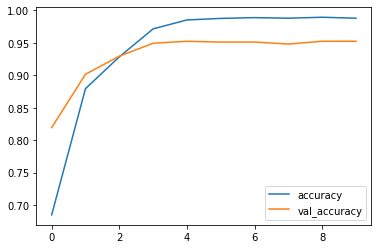

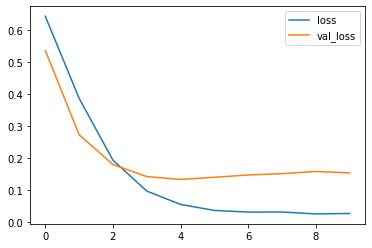

In [19]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

7/7 [==============================] - 2s 291ms/step - loss: 0.1545 - accuracy: 0.9522
[0.1545204222202301, 0.9522370100021362]


In [22]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       795
           1       0.97      0.93      0.95       859

    accuracy                           0.95      1654
   macro avg       0.95      0.95      0.95      1654
weighted avg       0.95      0.95      0.95      1654



In [23]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),771,24
Acutal: Pork (1),61,798


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [24]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [25]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [26]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
2601,李復興,0.999978661537170,發現自九十三年一月間起，勞保局陸續清查有一千多名國、公營事業退休員工溢領敬老津貼，截至93年...,老年給付 ; 勞工退休,公營事業退休員工 ; 溢領敬老津貼
3999,林正峰,0.999970257282257,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
7382,盧秀燕,0.999949336051941,針對早期退除役軍官給與補助金發放金額過低，實無法解決終身生活所需，希望相關單位考量實際情況，...,榮民福利,早期退除役軍官給與補助金
9109,邱鏡淳,0.999935269355774,就政府為減緩政府財政負擔及維持退休人員與現職人員權益的平衡，推行「教育人員退休所得合理化方案...,教育人員退休 ; 退休金,教育人員 ; 退休所得
4553,林鴻池,0.999877452850342,針對行政院宣布補助弱勢家庭子女就讀私校高中職之學費，卻將資格限制在「非自願就讀者」，有畫餅充...,低收入戶 ; 教育補助,弱勢家庭 ; 私立高中職
58,丁守中,0.999864578247070,針就媒體報導近年低收入戶審查標準從嚴，坊間陸續出現抽佣代辦各項急難補助的「社福黃牛」，遊走在...,保險給付 ; 代理人,社福黃牛 ; 弱勢 ; 低收入戶
6899,王昱婷,0.999843597412109,針對根據內政部最新統計，國內的嬰兒出生率再創新低點，今年1到4月只有6萬5400個小嬰兒出生...,出生率 ; 人口政策,出生率 ; 生育率
35,丁守中,0.999838113784790,針就民眾陳情指出，目前政府對身心障礙者提供之生活津貼，依身心障礙程度等級分為1000元至50...,身心障礙者福利,身心障礙者生活津貼
533,吳志揚,0.999815344810486,針對政府打著照顧中產階級的漂亮旗號，擬調增受薪大眾的薪資特別扣除額，但是只在薪資扣除額調整幅...,薪資扣除額,薪資特別扣除額
10471,馮定國,0.999810874462128,鑒於國內經濟結構的快速調整，與人口高齡化的進展，未來中高齡失業問題必將日益嚴重，致使國人老年...,老人福利,高齡化 ; 中高齡失業


##### Last 10 Rows of 2000 Samples

In [27]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
2439,李俊毅,0.010597437620163,針對近來國務機要費與首長特別費因相關規範未臻明確，遭質疑該筆金額等同於首長薪水或私房錢，且有...,國家元首 ; 行政首長 ; 統一發票,國務機要費 ; 首長特別費
5160,沈智慧,0.008501231670380,針對考試院修正特種考試地方政府公務人員考試規則，新增並刪減多項類科，且將三等、四等及五等考試...,國家考試,國家考試 ; 憲法
9164,郭林勇,0.008108228445053,鑑於現今台灣新聞媒體過於腥、羶、色，大幅報導政治惡鬥、社會黑暗面，並且過於詳細描寫各類自殺、...,新聞事業 ; 新聞道德,新聞媒體 ; 新聞道德
7985,羅志明,0.008101910352707,針對衛星電視換照審議委員會進行營運審查招致在野黨指控為打壓新聞自由乙事，主管機關應公正審議，...,有線電視 ; 執照,衛星電視 ; 換照 ; 新聞自由
5739,潘孟安,0.007899075746536,關心目前電子垃圾郵件氾濫，於立法程序完成前，主管機關應積極制定政策，並協調電信服務業者採取防...,電子郵件,垃圾郵件
5869,王世堅,0.007714718580246,針對「台大校長遴選」一事，特向行政院提出質詢。,大學 ; 教育人員任用,台大校長遴選
7592,紀國棟,0.006676316261292,針對國道高速公路局及相關工程單位對四號公路神岡段堤防治理成效不彰，特向行政院提出質詢。,高速公路 ; 堤防工程,四號公路 ; 堤防治理
2538,李復甸,0.006557345390320,鑑於刑事實務上以行政簽結之方式終結偵查，不僅嚴重侵害當事人權利、架空偵查法定原則及規避不起訴...,刑事訴訟 ; 偵查,行政簽結 ; 訴訟權 ; 依法行政原則
473,吳光訓,0.006494283676147,為修訂「公開發行公司出席股東會使用委託書規則」及「股務處理準則」事宜，特向行政院提出質詢。,股東 ; 金融管理,出席股東會 ; 委託書
1919,徐國勇,0.005139768123627,針對公司法所規範董事會職能等問題，特向行政院提出質詢。,公司 ; 董事會,公司法 ; 董事會職能


#### (2) Export an End-to-end Model


In [28]:
from tensorflow.keras.models import load_model

In [29]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [30]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')